Explore CC-Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

Convert Dataset to usable format

In [33]:
datetime_cols = ["call_started", "call_answered", "call_ended"]

df = pd.read_csv(
    "../data/raw/call-centre-queue-simulation/simulated_call_centre.csv",
    parse_dates=["date"]
)

# Remove 'call_id' column if it exists
if 'call_id' in df.columns:
    df = df.drop(columns=['call_id'])

# Convert call time columns to datetime objects for calculation
time_format = "%I:%M:%S %p"  # Example: 01:23:45 PM
for col in datetime_cols:
    df[col] = pd.to_datetime(df[col], format=time_format)

# Example: Calculate call duration in seconds
# df["call_duration"] = (df["call_ended"] - df["call_answered"]).dt.total_seconds()

display(df)
df.dtypes

,date,daily_caller,call_started,call_answered,call_ended,wait_length,service_length,meets_standard
0,2021-01-01,1,1900-01-01 08:00:00,1900-01-01 08:00:00,1900-01-01 08:14:22,0,863,True
1,2021-01-01,2,1900-01-01 08:02:42,1900-01-01 08:02:42,1900-01-01 08:07:31,0,289,True
2,2021-01-01,3,1900-01-01 08:08:24,1900-01-01 08:08:24,1900-01-01 08:10:13,0,108,True
3,2021-01-01,4,1900-01-01 08:09:37,1900-01-01 08:09:37,1900-01-01 08:13:45,0,247,True
4,2021-01-01,5,1900-01-01 08:11:10,1900-01-01 08:11:10,1900-01-01 08:15:28,0,258,True
...,...,...,...,...,...,...,...,...
51703,2021-12-31,267,1900-01-01 17:50:10,1900-01-01 17:50:10,1900-01-01 17:57:26,0,436,True
51704,2021-12-31,268,1900-01-01 17:50:31,1900-01-01 17:50:31,1900-01-01 17:54:55,0,265,True
51705,2021-12-31,269,1900-01-01 17:51:29,1900-01-01 17:51:29,1900-01-01 17:54:26,0,177,True
51706,2021-12-31,270,1900-01-01 17:53:10,1900-01-01 17:54:26,1900-01-01 17:57:50,76,204,False


date              datetime64[ns]
daily_caller               int64
call_started      datetime64[ns]
call_answered     datetime64[ns]
call_ended        datetime64[ns]
wait_length                int64
service_length             int64
meets_standard              bool
dtype: object

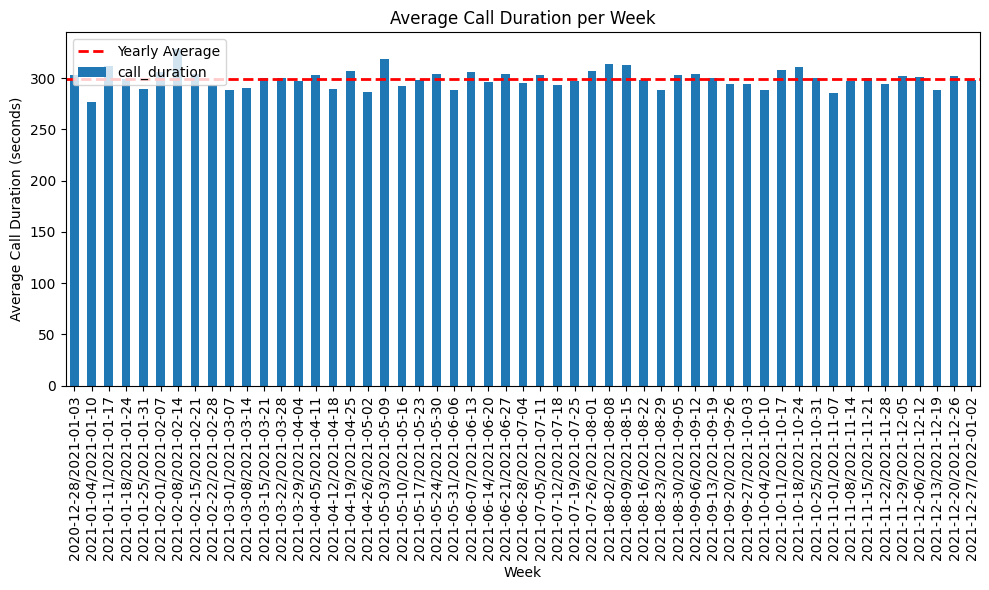

In [24]:
# Calculate average call_duration for each week
avg_call_duration_per_week = df.groupby(df['date'].dt.to_period('W'))["call_duration"].mean()

# Calculate average call duration for the whole year
yearly_avg_call_duration = df["call_duration"].mean()

# Visualize the result
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
avg_call_duration_per_week.plot(kind='bar')
plt.axhline(yearly_avg_call_duration, color='red', linestyle='--', linewidth=2, label='Yearly Average')
plt.ylabel('Average Call Duration (seconds)')
plt.xlabel('Week')
plt.title('Average Call Duration per Week')
plt.legend()
plt.tight_layout()
plt.show()

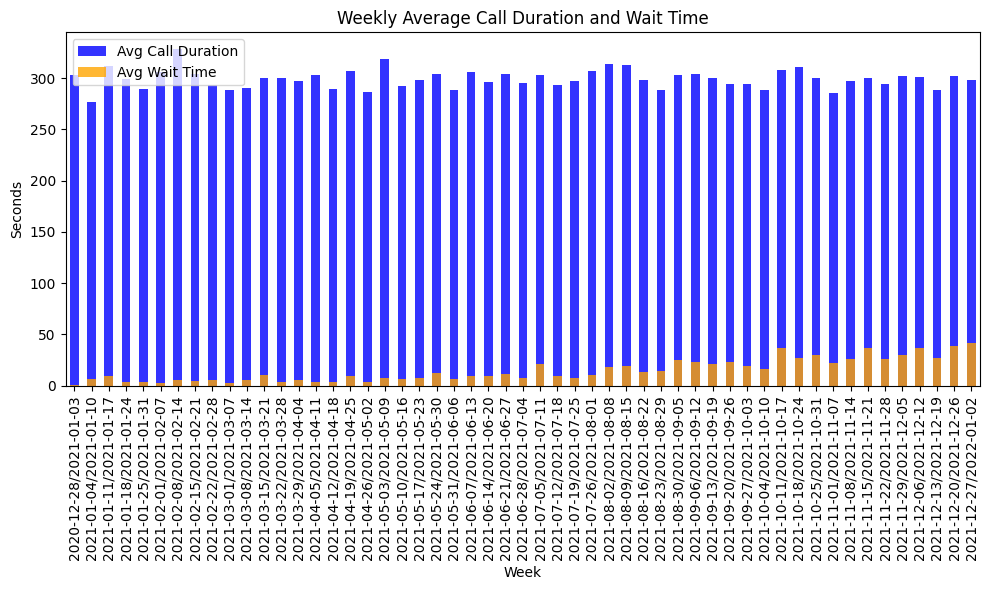

In [4]:
# Calculate wait time (in seconds) as the difference between call_answered and call_started
df['wait_time'] = (df['call_answered'] - df['call_started']).dt.total_seconds()

# Calculate average call duration and wait time per week
avg_call_duration_per_week = df.groupby(df['date'].dt.to_period('W'))['call_duration'].mean()
avg_wait_time_per_week = df.groupby(df['date'].dt.to_period('W'))['wait_time'].mean()

# Overlay both graphs
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
avg_call_duration_per_week.plot(kind='bar', alpha=0.8, color='blue', label='Avg Call Duration')
avg_wait_time_per_week.plot(kind='bar', alpha=0.8, color='orange', label='Avg Wait Time')
plt.ylabel('Seconds')
plt.xlabel('Week')
plt.title('Weekly Average Call Duration and Wait Time')
plt.legend()
plt.tight_layout()
plt.show()

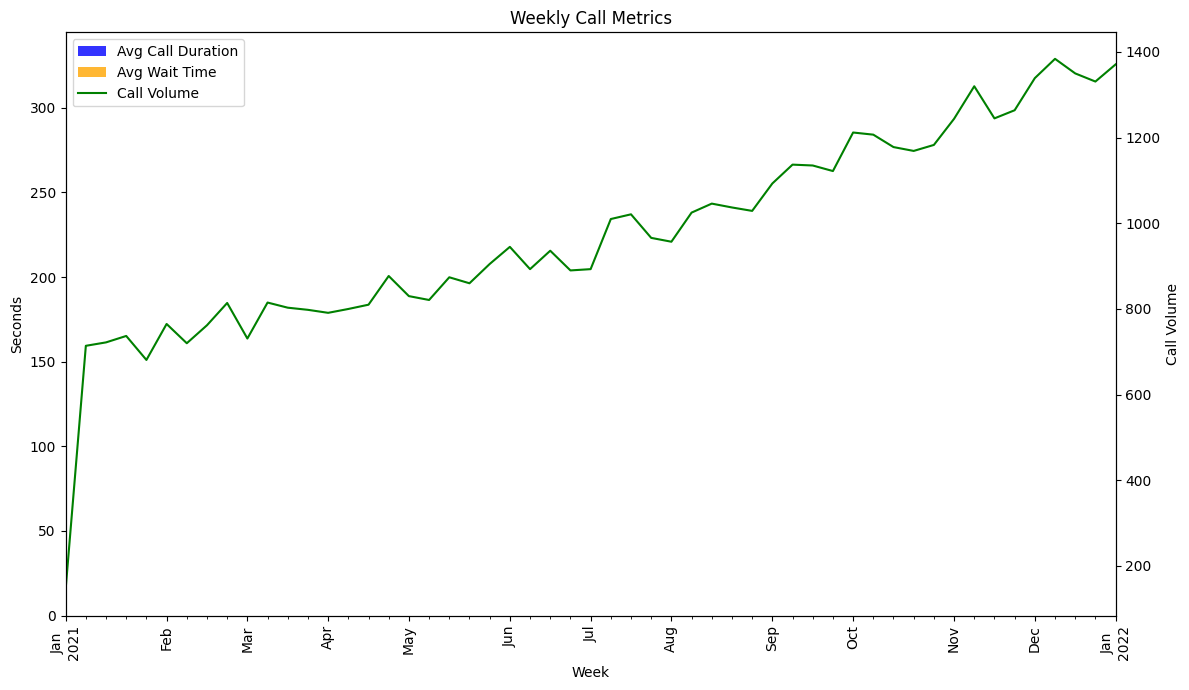

In [5]:
# Calculate weekly metrics
avg_call_duration_per_week = df.groupby(df['date'].dt.to_period('W'))['call_duration'].mean()
avg_wait_time_per_week = df.groupby(df['date'].dt.to_period('W'))['wait_time'].mean()
call_volume_per_week = df.groupby(df['date'].dt.to_period('W')).size()

# Combine all three graphs
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,7))

# Plot call duration and wait time on left y-axis
avg_call_duration_per_week.plot(kind='bar', alpha=0.8, color='blue', label='Avg Call Duration', ax=ax1)
avg_wait_time_per_week.plot(kind='bar', alpha=0.8, color='orange', label='Avg Wait Time', ax=ax1)
ax1.set_ylabel('Seconds')
ax1.set_xlabel('Week')
ax1.set_title('Weekly Call Metrics')

# Plot call volume on right y-axis
ax2 = ax1.twinx()
call_volume_per_week.plot(kind='line', color='green', label='Call Volume', ax=ax2)
ax2.set_ylabel('Call Volume')

# Legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.tight_layout()
plt.show()

In [7]:
# Forecast the number of calls for the next 8 weeks using ARIMA
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Aggregate call volume per week
call_volume_per_week = df.groupby(df['date'].dt.to_period('W')).size()
call_volume_per_week.index = call_volume_per_week.index.to_timestamp()

# Fit ARIMA model
model = SARIMAX(call_volume_per_week, order=(1,1,1), seasonal_order=(1,1,1,52))
results = model.fit()

# Forecast next 8 weeks
forecast = results.get_forecast(steps=8)
predicted_calls = forecast.predicted_mean

print('Predicted call volume for the next 8 weeks:')
print(predicted_calls)

c:\Users\avtma\Documents\Python\DPP_Callcenter\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
c:\Users\avtma\Documents\Python\DPP_Callcenter\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


Predicted call volume for the next 8 weeks:
2022-01-03    1939.0
2022-01-10    1947.0
2022-01-17    1962.0
2022-01-24    1906.0
2022-01-31    1990.0
2022-02-07    1945.0
2022-02-14    1987.0
2022-02-21    2039.0
Freq: W-MON, Name: predicted_mean, dtype: float64


c:\Users\avtma\Documents\Python\DPP_Callcenter\.venv\Lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


In [16]:
# Estimate number of needed agents per week using predicted call volume, average call duration, and target service level (Erlang C)
from scipy.special import factorial
import numpy as np
def erlang_c_prob(A, N):
    # Offered load A, number of agents N
    numer = (A**N / factorial(N, exact=False)) * (N / (N - A))
    denom = sum([A**k / factorial(k, exact=False) for k in range(N)]) + numer
    return numer / denom
def expected_wait_time(A, N, avg_service_time):
    # Returns expected wait time in seconds
    pw = erlang_c_prob(A, N)
    return pw * avg_service_time / (N - A) if N > A else float('inf')

target_service_level = 0.9  # Fraction of calls to be answered within target wait time
target_wait_time = 60  # seconds (example target)
avg_call_duration = df['call_duration'].mean()  # average call duration in seconds

needed_agents = []
max_agents = 50  # Reasonable upper bound for call center
for week_calls in predicted_calls:
    arrival_rate = week_calls / (5 * 24 * 3600)  # calls per second (assuming week has 7 days)
    A = arrival_rate * avg_call_duration  # offered load (Erlangs)
    agents = int(A) + 1
    while agents < max_agents:
        pw = erlang_c_prob(A, agents)
        ewt = expected_wait_time(A, agents, avg_call_duration)
        # Service level: fraction of calls answered within target_wait_time
        service_level = 1 - pw * np.exp(-(agents - A) * target_wait_time / avg_call_duration)
        if service_level >= target_service_level:
            break
        agents += 1
    needed_agents.append(agents)
print('Estimated number of agents needed per week for next 8 weeks (Erlang C):')
print(needed_agents)

Estimated number of agents needed per week for next 8 weeks (Erlang C):
[4, 4, 4, 4, 4, 4, 4, 4]


In [17]:
# Apply Erlang C function to each week in the dataframe
results = []
for week, group in df.groupby(df['date'].dt.to_period('W')):
    week_calls = len(group)
    arrival_rate = week_calls / (5 * 24 * 3600)
    avg_call_duration_week = group['call_duration'].mean()
    A = arrival_rate * avg_call_duration_week
    agents = int(A) + 1
    max_agents = 50
    while agents < max_agents:
        pw = erlang_c_prob(A, agents)
        ewt = expected_wait_time(A, agents, avg_call_duration_week)
        service_level = 1 - pw * np.exp(-(agents - A) * target_wait_time / avg_call_duration_week)
        if service_level >= target_service_level:
            break
        agents += 1
    results.append({
        'week': str(week),
        'calls': week_calls,
        'agents_needed': agents,
        'service_level': service_level,
        'expected_wait_time': ewt
    })
import pandas as pd
erlang_c_df = pd.DataFrame(results)
print(erlang_c_df)

                     week  calls  agents_needed  service_level  \
0   2020-12-28/2021-01-03    146              1       0.914222   
1   2021-01-04/2021-01-10    714              2       0.938886   
2   2021-01-11/2021-01-17    722              2       0.918808   
3   2021-01-18/2021-01-24    737              2       0.922960   
4   2021-01-25/2021-01-31    681              2       0.938349   
5   2021-02-01/2021-02-07    765              2       0.913453   
6   2021-02-08/2021-02-14    720              2       0.909934   
7   2021-02-15/2021-02-21    762              2       0.915124   
8   2021-02-22/2021-02-28    814              2       0.911248   
9   2021-03-01/2021-03-07    731              2       0.930078   
10  2021-03-08/2021-03-14    815              2       0.912548   
11  2021-03-15/2021-03-21    803              2       0.909010   
12  2021-03-22/2021-03-28    798              2       0.909882   
13  2021-03-29/2021-04-04    791              2       0.913027   
14  2021-0

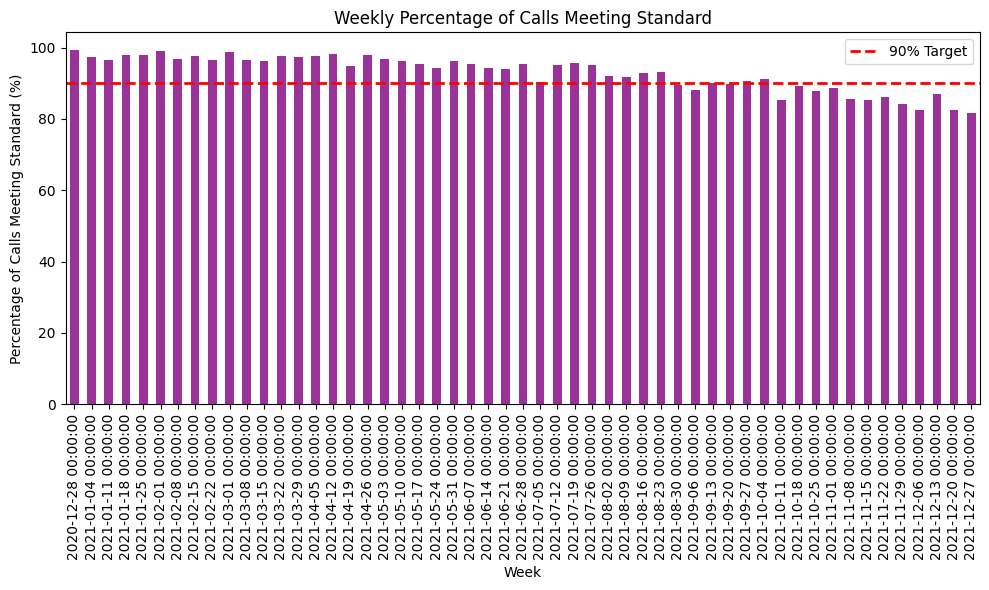

In [23]:
# Weekly diagram: percentage of calls where meet_standard is True
weekly_total_calls = df.groupby(df['date'].dt.to_period('W')).size()
weekly_meet_standard = df[df['meets_standard'] == True].groupby(df['date'].dt.to_period('W')).size()
weekly_meet_standard.index = weekly_meet_standard.index.to_timestamp()
weekly_total_calls.index = weekly_total_calls.index.to_timestamp()
weekly_percentage = (weekly_meet_standard / weekly_total_calls * 100).fillna(0)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
weekly_percentage.plot(kind='bar', color='purple', alpha=0.8)
plt.axhline(90, color='red', linestyle='--', linewidth=2, label='90% Target')
plt.ylabel('Percentage of Calls Meeting Standard (%)')
plt.xlabel('Week')
plt.title('Weekly Percentage of Calls Meeting Standard')
plt.legend()
plt.tight_layout()
plt.show()

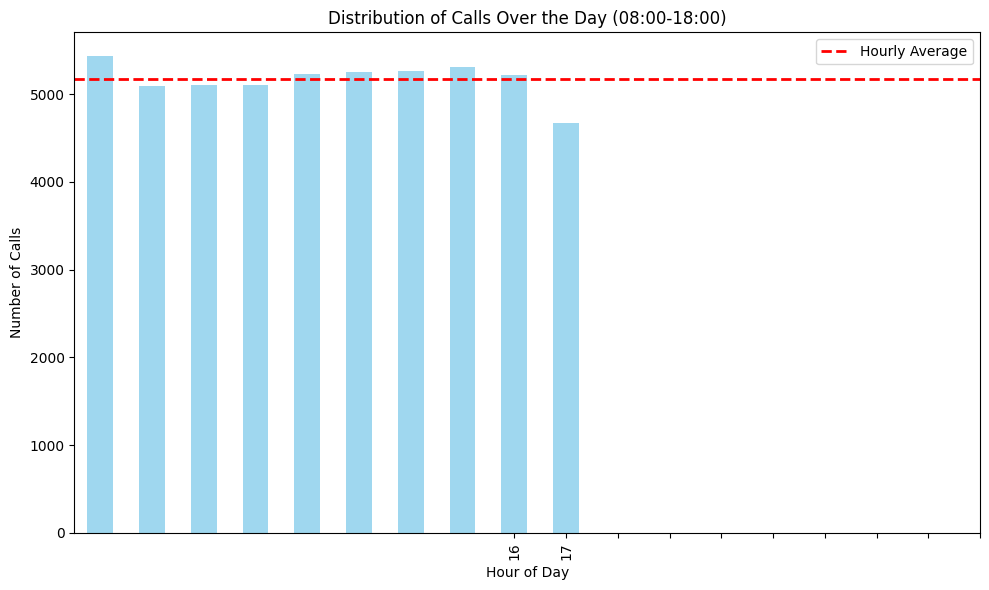

In [32]:
# Plot distribution of calls over the day (08:00 to 18:00)
df['hour'] = df['call_started'].dt.hour
calls_per_hour = df[(df['hour'] >= 8) & (df['hour'] < 18)].groupby('hour').size()
avg_calls_per_hour = calls_per_hour.mean()
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
calls_per_hour.plot(kind='bar', color='skyblue', alpha=0.8)
plt.axhline(avg_calls_per_hour, color='red', linestyle='--', linewidth=2, label='Hourly Average')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Calls')
plt.title('Distribution of Calls Over the Day (08:00-18:00)')
plt.xticks(range(8,18))
plt.legend()
plt.tight_layout()
plt.show()